## Dependencies

In [8]:
from siphon.catalog import TDSCatalog
import xarray as xr
import geopandas as gpd
import rioxarray
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
import math
import time
from tqdm import tqdm
from dask.diagnostics import ProgressBar
from rasterio.warp import Resampling

## Load parcels and find corresponding tiles

In [2]:
parcels = gpd.read_file("zip://Data/Target_LLS.zip")
parcels = parcels.to_crs("EPSG:4326")  # ensure CRS matches MODIS

# MODIS Sinusoidal grid parameters
R = 6371007.181  # radius
TILE_SIZE = 1111950  # size of tile in meters
NX = 36  # tiles horizontal
NY = 18  # tiles vertical

# Sinusoidal projection for MODIS
modis_proj = Proj("+proj=sinu +R=6371007.181 +units=m +no_defs")
wgs84 = Proj("EPSG:4326")
transformer = Transformer.from_proj(wgs84, modis_proj, always_xy=True)

def lonlat_to_modis_tile(lon, lat):
    x, y = transformer.transform(lon, lat)
    h = math.floor((x + (TILE_SIZE*NX/2)) / TILE_SIZE)
    v = math.floor((NY*TILE_SIZE/2 - y) / TILE_SIZE)
    return h, v

parcel_tiles = set()

for geom in parcels.geometry:
    lon, lat = geom.centroid.x, geom.centroid.y
    h, v = lonlat_to_modis_tile(lon, lat)
    parcel_tiles.add((h,v))

print("Tiles covering parcels:", parcel_tiles)

Tiles covering parcels: {(30, 12)}


## Access the dataset

In [3]:
catUrl = "https://thredds.nci.org.au/thredds/catalog/tc43/modis-fc/v310/tiles/monthly/cover/catalog.xml"
catalog = TDSCatalog(catUrl)

filtered_datasets = [
    name for name in catalog.datasets
    if any(f"h{h:02d}v{v:02d}" in name for h,v in parcel_tiles)
]

print("Filtered datasets:", filtered_datasets)

Filtered datasets: ['FC_Monthly_Medoid.v310.MCD43A4.h30v12.2001.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2002.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2003.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2004.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2005.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2006.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2007.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2008.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2009.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2010.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2011.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2012.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2013.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2014.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2015.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2016.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2017.006.nc', 'FC_Monthly_Medoid.v310.MCD43A4.h30v12.2018.006.nc', 'FC_Monthly_Medoid.v310.MC

## Build datacube

In [ ]:
# URL for the 2025 MODIS tile
url = "https://thredds.nci.org.au/thredds/dodsC/tc43/modis-fc/v310/tiles/monthly/cover/FC_Monthly_Medoid.v310.MCD43A4.h30v12.2025.061.nc"

# Open dataset lazily with dask chunks
ds = xr.open_dataset(url, chunks={'x': 500, 'y': 500, 'time': 1})
da = ds['tot_cov'].where(ds['tot_cov'] < 255).astype(float)  # mask no-data

# Compute mean across all time slices
print("Computing per-pixel mean for 2025...")
with ProgressBar():
    mean_2025 = da.mean(dim='time').compute()

# Convert to rioxarray and assign MODIS sinusoidal CRS
mean_2025 = mean_2025.rio.write_crs(
    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext +units=m +no_defs",
    inplace=True
)

# Reproject to WGS84 (lat/lon)
mean_2025_wgs84 = mean_2025.rio.reproject(
    "EPSG:4326",
    resampling=Resampling.bilinear  # use bilinear for continuous data
)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(mean_2025_wgs84.values, cmap='viridis', origin='upper')
plt.colorbar(label='Total Cover (%)')
plt.title("Mean tot_cov for 2025 (WGS84)")
plt.show()

Computing per-pixel mean for 2025...
[####################################### ] | 98% Completed | 57.64 ss

## Testing

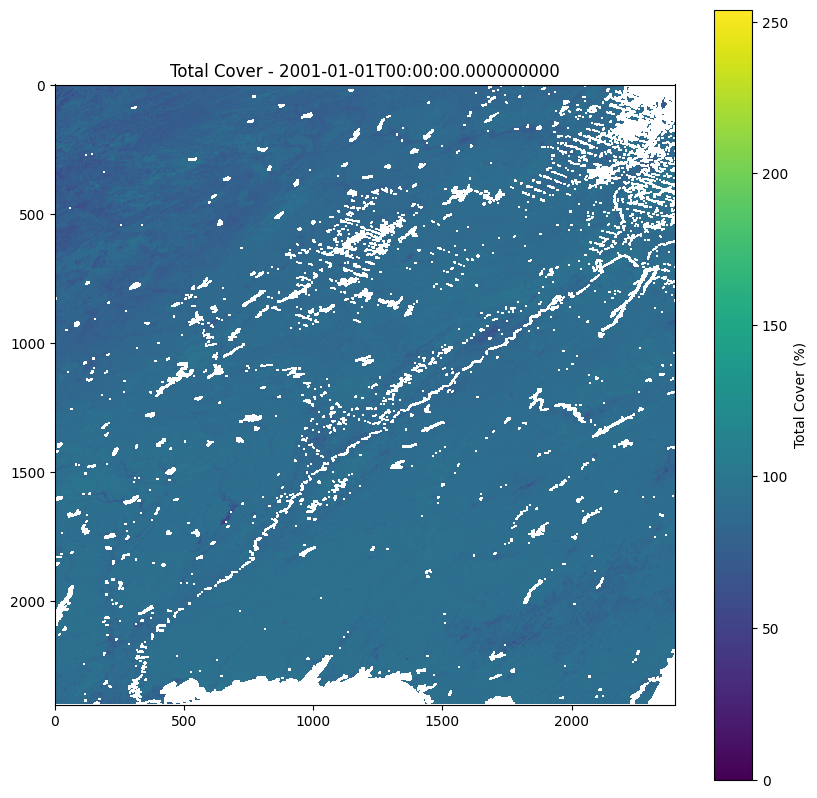

In [12]:
# Use a tile covering land (change h/v as needed)
url = "https://thredds.nci.org.au/thredds/dodsC/tc43/modis-fc/v310/tiles/monthly/cover/FC_Monthly_Medoid.v310.MCD43A4.h10v05.2001.006.nc"

ds = xr.open_dataset(url)
da = ds['tot_cov'].isel(time=0).load()  # first month

# Convert Byte to float and set no-data (255) to np.nan
da = da.astype(float)
da = da.where(da < 255)

# Quick plot
plt.figure(figsize=(10, 10))
plt.imshow(da.values, cmap='viridis', origin='upper')
plt.colorbar(label='Total Cover (%)')
plt.title(f"Total Cover - {str(da['time'].values)}")
plt.show()